# "Predicting Real Estate Unit Prices Using Deep Learning Techniques"

###  **Problem Statement:**

In the real estate market of Taipei, Taiwan, accurate property pricing is crucial for buyers, sellers, and investors. The goal of this project is to predict the price per unit area of residential properties using historical transaction data and property features. By leveraging a Feedforward Neural Network (FNN), we aim to build a robust model that helps estimate fair property values.

---

### **Business Insights from Dataset**
* Age vs. Price: Older houses tend to have lower prices per unit area.
* Proximity to MRT Station: Properties closer to MRT stations generally have higher value, showing the importance of public transport access.
* Convenience Stores: More nearby convenience stores slightly correlate with higher prices, possibly reflecting better urban infrastructure.
* Location Matters: Latitude and longitude indicate geographic differences in price trends.


---


## **1. Load Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## **2. Load Data**

In [ ]:
import os #Manually Delete Old Files Before re-uploading, delete any existing files with the same name to prevent renaming:

file_path = ".csv"
if os.path.exists(file_path):
    os.remove(file_path)

 #uploaded = files.upload()

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Real estate.csv to Real estate.csv
User uploaded file "Real estate.csv" with length 21968 bytes


In [ ]:
import io
data=pd.read_csv(io.StringIO(uploaded['Real estate.csv'].decode('utf-8')))
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [ ]:
data.shape

(414, 8)

## **3. Data Preprocessing**

### **3.1. Data Cleaning**

In [ ]:
data.dtypes

,0
No,int64
X1 transaction date,float64
X2 house age,float64
X3 distance to the nearest MRT station,float64
X4 number of convenience stores,int64
X5 latitude,float64
X6 longitude,float64
Y house price of unit area,float64


In [ ]:
data.drop(columns=["No"], inplace=True)

In [ ]:
data.shape

(414, 7)

In [ ]:
data.isnull().sum()

,0
X1 transaction date,0
X2 house age,0
X3 distance to the nearest MRT station,0
X4 number of convenience stores,0
X5 latitude,0
X6 longitude,0
Y house price of unit area,0


### **3.2. Handle Duplicates**

In [ ]:
duplicates = data.duplicated().sum()
duplicates

np.int64(0)

In [ ]:
duplicates = data[data.duplicated()]
duplicates

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area


### **3.3. Check inconsistencies and errors**

In [ ]:
# our data have no inconsistencies and errors

### **3.4. Encoding**

In [ ]:
data.dtypes

,0
X1 transaction date,float64
X2 house age,float64
X3 distance to the nearest MRT station,float64
X4 number of convenience stores,int64
X5 latitude,float64
X6 longitude,float64
Y house price of unit area,float64


In [ ]:
# our data is encoded

### **3.5. Handle Outliers**

In [ ]:
# Calculate outlier percentage for all features in the dataset using IQR method
def calculate_outlier_percentages(df):
    outlier_percentages = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_percentages[col] = len(outliers) / len(df) * 100  # Percentage of outliers
    return outlier_percentages

outlier_percentages_all = calculate_outlier_percentages(data)
outlier_percentages_all

{'X1 transaction date': 0.0,
 'X2 house age': 0.0,
 'X3 distance to the nearest MRT station': 8.937198067632849,
 'X4 number of convenience stores': 0.0,
 'X5 latitude': 1.932367149758454,
 'X6 longitude': 8.454106280193237,
 'Y house price of unit area': 0.7246376811594203}

In [ ]:
data.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [ ]:
# Real Estate dataset clean and well-balanced dataset, so outlier removal is usually not required.
# If the dataset is small and clean (like the Real Estate dataset), outliers may not have a big effect.
# If you standardize or normalize your data (which you already do with StandardScaler), the effect of outliers can be reduced.



### **3.6. EDA Visualization**

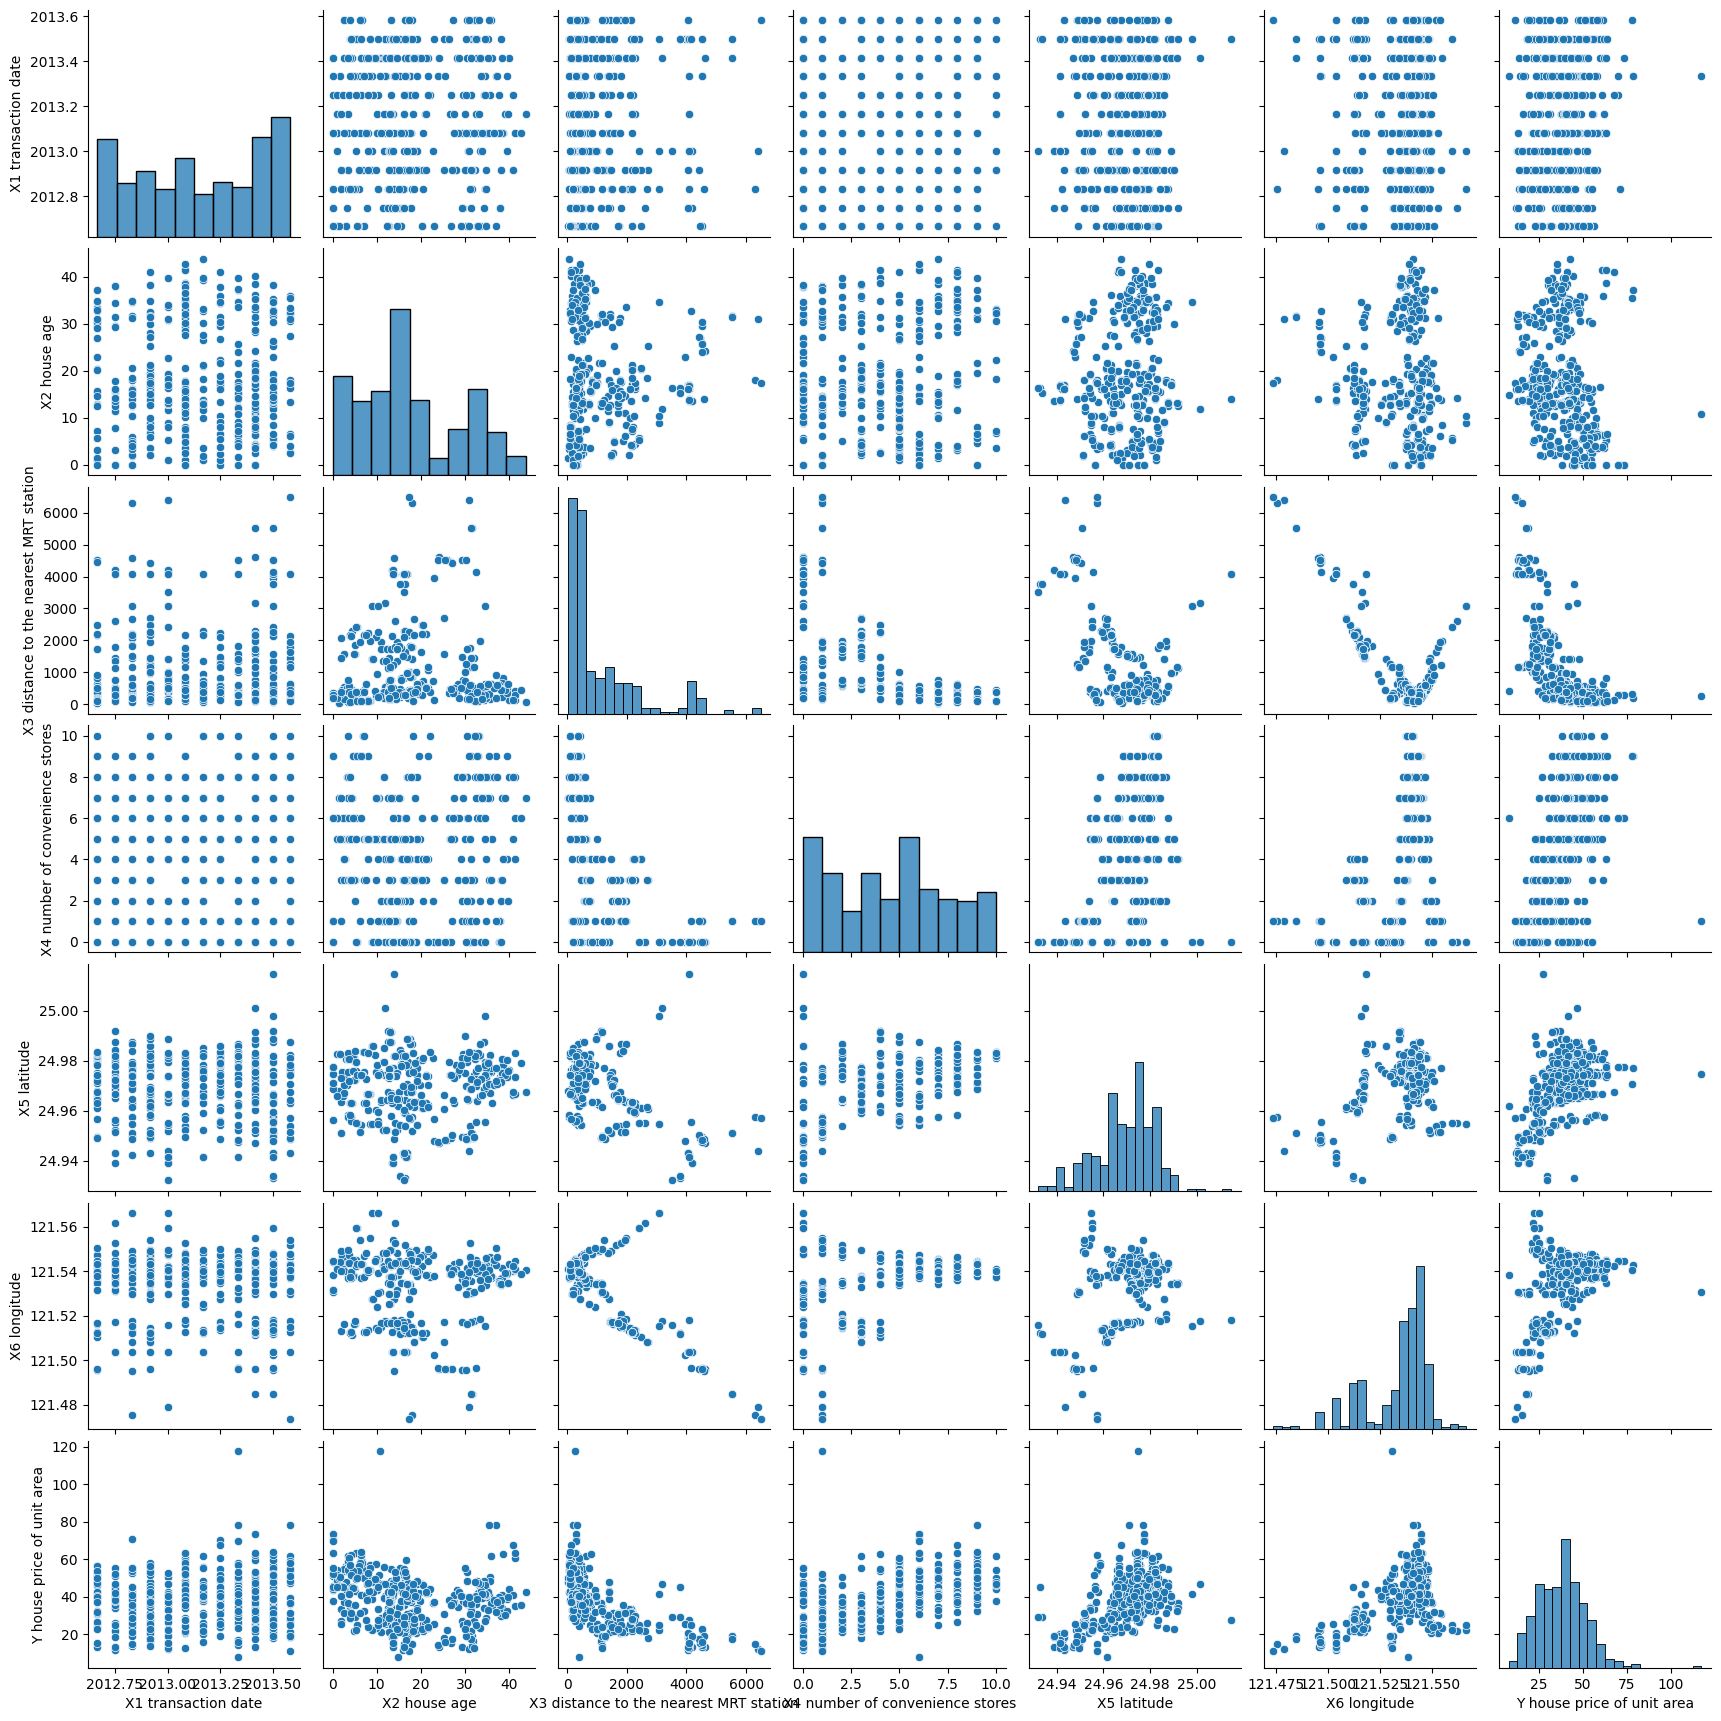

In [ ]:
sns.pairplot(data)
plt.show()

## **4. SCALING**

In [ ]:
data.shape

(414, 7)

In [ ]:
data.head(2)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2


In [ ]:
x = data.drop(columns="Y house price of unit area")
y = data['Y house price of unit area']

In [ ]:
# Scaling the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
x_scaled

array([[-0.82368321,  1.25562833, -0.79249504,  2.00740743,  1.12542986,
         0.44876222],
       [-0.82368321,  0.15708622, -0.61661163,  1.66750286,  0.91244418,
         0.40113894],
       [ 1.54115111, -0.38779067, -0.41401527,  0.30788458,  1.48686011,
         0.68818339],
       ...,
       [ 0.35873395,  0.09556786, -0.54967846,  0.98769372,  0.82289338,
         0.42397202],
       [-0.52896662, -0.84478419, -0.77668389,  0.30788458, -0.18475479,
         0.4768143 ],
       [ 1.24643452, -0.98539758, -0.78807071,  1.66750286,  0.42757905,
         0.63534112]])

In [ ]:
# Ensure x_scaled remains a DataFrame
# x_scaled is need in dataframe because in correlation .corr is work with dataframe, and x_scaled is a numpay array.
X = pd.DataFrame(x_scaled, columns=data.drop(columns=['Y house price of unit area']).columns)

In [ ]:
X.head(2)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,-0.823683,1.255628,-0.792495,2.007407,1.125430,0.448762
1,-0.823683,0.157086,-0.616612,1.667503,0.912444,0.401139


## **5. Feature Selection**

In [ ]:
# in this dataset no need to Feature selection

## **6. Model Selection and Training**

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
print('X shape = ',X.shape)
print('y shape = ', y.shape)
print('x train shape = ',x_train.shape)
print('x test shape = ', x_test.shape)
print('y train shape = ', y_train.shape)
print('y test shape = ',y_test.shape)

X shape =  (414, 6)
y shape =  (414,)
x train shape =  (331, 6)
x test shape =  (83, 6)
y train shape =  (331,)
y test shape =  (83,)


In [ ]:
# Define the model
model = Sequential()

# Input layer + Hidden Layer 1
model.add(Dense(units=10, input_shape=(6,), activation='relu'))

# Hidden Layer 2
model.add(Dense(units=8, activation='relu'))

# Output Layer
model.add(Dense(units=1, activation='linear'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [ ]:
# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 1623.7511
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1552.5065
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1514.2896
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1500.8042
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1444.2950
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1322.1246
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1165.1667
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 1173.4232
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 862.2385
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 724.8182
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss

In [ ]:
# Evaluate
y_pred = model.predict(x_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Mean Squared Error: 42.60
R² Score: 0.75


In [ ]:
y_pred.shape

(83,)

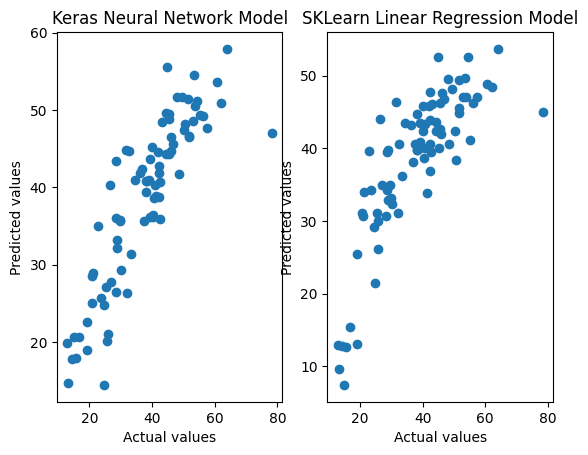

Linear Regression Model Mean Square Error
59.522435319028894


In [ ]:
#Multiple Linear Regression with the help of ML.
from sklearn.linear_model import LinearRegression

LModel = LinearRegression()
LModel.fit(x_train, y_train)

Y_predLM = LModel.predict(x_test)

plt.figure(1)
plt.subplot(121)
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Keras Neural Network Model")

plt.subplot(122)
plt.scatter(y_test, Y_predLM)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("SKLearn Linear Regression Model")
plt.show()

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, Y_predLM)
print('Linear Regression Model Mean Square Error')
print(mse)

In [ ]:
# we see that mse in FNN is lower than classic ml rme.

In [ ]:
# Making predictions for new data (example with one test sample)
new_data = [[...]]  # Replace with the actual input features of the new data point
new_data_scaled = scaler.transform(new_data)  # Standardize the input
predicted_value = model.predict(new_data_scaled)
print(f"Predicted house price: {predicted_value[0][0]}")